In [139]:
# Run with 'solar': conda
from tsai.all import *

Create `numpy` array with four columns.

In [140]:
data1 = np.concatenate([np.ones((20,1), dtype=int), np.arange(20).reshape(-1,1).repeat(3,1) * np.array([1,10,100])], 1)
data2 = np.concatenate([np.ones((15,1), dtype=int)*2, np.arange(15).reshape(-1,1).repeat(3,1) * np.array([1,10,100]) + .5], 1)
data = np.concatenate([data1, data2])

Create `dataframe` with four columns.

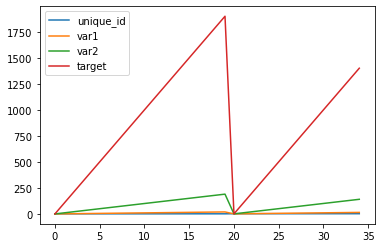

In [141]:
df = pd.DataFrame(data, columns=['unique_id', 'var1', 'var2', 'target'])
df.plot();

In [142]:
df = df.loc[np.random.choice(len(df), len(df), False)].reset_index()
df.rename(columns={'index': 'time'}, inplace=True)

`SlidingWindow` parameters.

In [143]:
window_len = 3
unique_id_cols = ['unique_id']
stride = 1
start = 0
pad_remainder = False
padding_value = np.nan
add_padding_feature = True
get_x = ['var1', 'var2', 'target']
get_y = 'target'
y_func = None
horizon = 3                             # ?
seq_first = True
sort_by = ['time']
ascending = True
check_leakage = True
return_key = False
verbose = True

Apply `SlidingWindowPanel` on data.

In [144]:
X, y = SlidingWindowPanel(window_len=window_len,
                          unique_id_cols=unique_id_cols,
                          stride=stride,
                          start=start,
                          pad_remainder=pad_remainder,
                          padding_value=padding_value,
                          add_padding_feature=add_padding_feature,
                          get_x=get_x,
                          get_y=get_y,
                          y_func=y_func,
                          horizon=horizon,
                          seq_first=seq_first,
                          sort_by=sort_by,
                          ascending=ascending,
                          check_leakage=check_leakage,
                          return_key=return_key,
                          verbose=verbose)(df)

Faster way to apply `SlidingWindow`.

In [145]:
output = [df.groupby(['unique_id']).apply(lambda x: SlidingWindow(window_len=window_len,
                                                                  stride=stride,
                                                                  start=start,
                                                                  pad_remainder=pad_remainder,
                                                                  padding_value=padding_value,
                                                                  add_padding_feature=add_padding_feature,
                                                                  get_x=get_x,
                                                                  get_y=get_y,
                                                                  y_func=y_func,
                                                                  horizon=horizon,
                                                                  seq_first=seq_first,
                                                                  sort_by=sort_by,
                                                                  ascending=ascending,
                                                                  check_leakage=check_leakage,
                                                                  copy=True, # it's important to set copy to True when used in this way!!!
                                                                  )(x))][0].values

X2 = np.concatenate([oi[0] for oi in output])
y2 = np.concatenate([oi[1] for oi in output])

(Samples, Features, Timesteps)

In [146]:
print(X.shape, y.shape)
print(X2.shape, y2.shape)

(25, 3, 3) (25, 3)
(25, 3, 3) (25, 3)


In [147]:
X[0,0,:]

array([0., 1., 2.])